<a href="https://colab.research.google.com/github/wahyunirosyidah/cobapush/blob/main/ML_Side.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.models import Model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Project Capstone'

Mounted at /content/drive
/content/drive/MyDrive/Project Capstone


In [ ]:
# Directory Path
BASE_DIR = 'Dataset'
print(f"Base Directory: {os.listdir(BASE_DIR)}")

data_train='Dataset/train'
print(f"Data Directory: {os.listdir(data_train)}")
data_validation='Dataset/valid'
print(f"Data Directory: {os.listdir(data_validation)}")


Base Directory: ['train', 'valid']
Data Directory: ['Belimbing Sayur', 'Bunga Lawang', 'Mengkudu', 'Kunyit', 'Jahe', 'Jeruk Nipis', 'Lengkuas']
Data Directory: ['Jahe', 'Belimbing Sayur', 'Bunga Lawang', 'Mengkudu', 'Lengkuas', 'Kunyit', 'Jeruk Nipis']


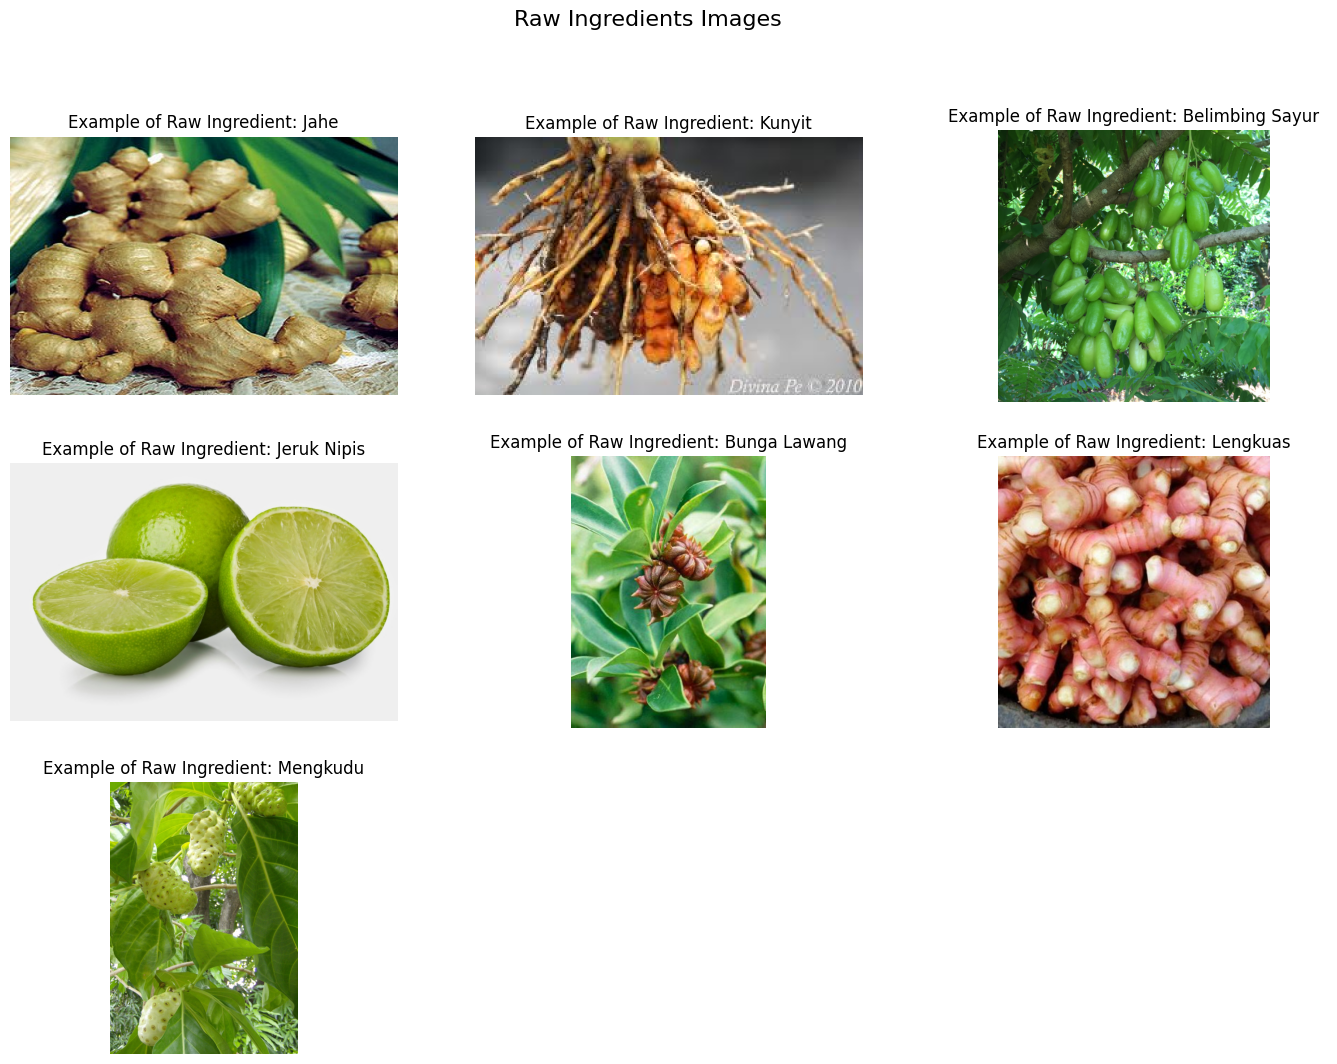

In [ ]:
# Plot Raw Ingredient Images
fig, axes = plt.subplots(3, 3, figsize=(17, 12))
fig.suptitle('Raw Ingredients Images', fontsize=16)

# List of Ingredients
ingredients_list = ['Jahe', 'Kunyit', 'Belimbing Sayur', 'Jeruk Nipis', 'Bunga Lawang', 'Lengkuas', 'Mengkudu']

# Plot images for each ingredient
for ii, ingredient in enumerate(ingredients_list):
    dir_path = f'./Dataset/train/{ingredient}'
    img = tf.keras.preprocessing.image.load_img(dir_path + '/' + os.listdir(dir_path)[0])
    row, col = divmod(ii, 3)
    axes[row, col].imshow(img)
    axes[row, col].set_title(f'Example of Raw Ingredient: {ingredient}')
    axes[row, col].axis('off')

# Disable axis on empty subplots if any
for jj in range(len(ingredients_list), 9):
    row, col = divmod(jj, 3)
    axes[row, col].axis('off')

plt.show()

In [ ]:
# Display Image Size
sample_array = tf.keras.preprocessing.image.img_to_array(img)
print(f"Each image has size: {sample_array.shape}")


Each image has size: (2146, 1478, 3)


In [ ]:
# Buat model dengan EfficientNetV2-L
def create_efficientnetv2l_model(num_classes):
    # Load model EfficientNetV2-L tanpa lapisan atas (top layer)
    base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze semua layer di EfficientNetV2-L agar bobotnya tidak ikut dilatih
    base_model.trainable = False

    # Tambahkan layer tambahan setelah EfficientNetV2-L
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Buat model akhir
    model = Model(inputs, outputs)

    # Kompilasi model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Contoh pemakaian
num_classes = 7  # Ganti dengan jumlah kelas sesuai dataset Anda
model_efficientnet = create_efficientnetv2l_model(num_classes)
model_efficientnet.summary()

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-l (Functional)        │ (None, 7, 7, 1280)          │     117,746,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 62720)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      32,113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,863,591 (571.68 MB)

 Trainable params: 32,116,743 (122.52 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)  # EfficientNetV2-L menggunakan resolusi 224x224
LABEL_MODE = 'categorical'
EPOCHS = 500
num_classes = 7  # Ganti dengan jumlah kelas sesuai dataset Anda


In [ ]:
# Inisiasi Dataset
# Instantiate the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_train,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

# Instantiate the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_validation,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode=LABEL_MODE
    )

Found 2194 files belonging to 7 classes.
Found 347 files belonging to 7 classes.


In [ ]:
# Optimization
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (
    train_dataset
    .cache()
    .shuffle(SHUFFLE_BUFFER_SIZE)
    .prefetch(PREFETCH_BUFFER_SIZE)
)

validation_dataset_final = (
    validation_dataset
    .cache()
    .prefetch(PREFETCH_BUFFER_SIZE)
)

In [ ]:
# Callbacks
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        if train_accuracy >= 0.95 and val_accuracy >= 0.85:
            self.model.stop_training = True
            print("\nReached 95% train accuracy and 85% validation accuracy, so cancelling training!")


In [ ]:
# Training Constants
EPOCHS = 500

# Train the Model
history = model_efficientnet.fit(
    train_dataset_final,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_dataset_final,
    callbacks=[EarlyStoppingCallback()]
)

Epoch 1/500
35/69 ━━━━━━━━━━━━━━━━━━━━ 13:14 23s/step - accuracy: 0.6561 - loss: 1.1498

KeyboardInterrupt: 

Augmentation

In [ ]:
FILL_MODE='nearest'
# Membuat layer augmentasi data
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),# Membalik gambar secara horizontal
    RandomRotation(0.2, fill_mode=FILL_MODE), # Rotasi gambar hingga 20%
    RandomZoom(0.2, fill_mode=FILL_MODE),  # Zoom gambar hingga 20%
    RandomContrast(0.2), # Mengubah kontras gambar hingga 20%
    RandomTranslation(0.1, 0.1, fill_mode=FILL_MODE) # Translasi (geser) gambar hingga 10% horizontal dan vertikal
])

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


NameError: name 'data_augmentation' is not defined

In [ ]:
# Fungsi untuk membuat model EfficientNetV2-L dengan layer tambahan
def create_efficientnetv2l_model_aug(num_classes):
    # Load model EfficientNetV2-L tanpa lapisan atas (top layer)
    base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze semua layer di EfficientNetV2-L agar bobotnya tidak ikut dilatih
    base_model.trainable = False

    # Tambahkan layer tambahan setelah EfficientNetV2-L
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)  # Terapkan augmentasi data
    x = base_model(x, training=False)  # Sambungkan augmentasi ke base model
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Buat model akhir
    model = Model(inputs, outputs)

    # Kompilasi model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Membuat model
num_classes = 7  # Ganti dengan jumlah kelas sesuai dataset Anda
model_efficientnet_aug = create_efficientnetv2l_model_aug(num_classes)
model_efficientnet_aug.summary()

In [ ]:
# Training model dengan data augmentasi
history = model_with_augmentation_aug.fit(
    train_dataset_final,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_dataset_final,
    callbacks=[EarlyStoppingCallback()]
)


In [ ]:
# Plot training and validation accuracy & loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and Validation Metrics')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [ ]:
# Get true labels and predictions for the validation set
y_true = np.concatenate([y for x, y in validation_dataset_final], axis=0)
y_pred = model_with_augmentation.predict(validation_dataset_final)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Define function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
class_names = ['Jahe', 'Jeruk Nipis', 'Kunyit', 'Bunga Lawang', 'Belimbing Sayur', 'Lengkuas', 'Mengkudu']  # Labels for ingredients
plot_confusion_matrix(conf_matrix, class_names)